In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import sys
import re

from mpl_toolkits import mplot3d

pd.set_option('display.max_columns', 9999)
np.set_printoptions(threshold=sys.maxsize)

%matplotlib notebook

In [2]:
med = pd.read_csv('eicu-collaborative-research-database-2.0/medication.csv.gz')

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def opioids (x):
    
    opiods = ['hydromorphone','hydrocodone','morphine','oxycodone','oxymorphone','codeine','fentanyl','meperidine',
          'tramadol','carfentanil','percocet','norco']

    for i in opiods:
        if i in str(x).lower():
            return 1
        
    return 0

In [4]:
def nsaids (x):
    
    non_op = ['acetaminophen','amitriptyline', 'doxepin', 'imipramine', 'desipramine', 'nortriptyline',
         'ibuprofen', 'naproxen', 'diclofenac', 'piroxicam', 'sulindac', 'indomethacin', 'ketorolac', 'meloxicam', 
          'celecoxib', 'ketoprofen', 'oxaprozin', 'toradol', 'valdecoxib', 'bextra', 'rofecoxib', 'vioxx', 'gabapentin', 
          'neurontin', 'cyclobenzaprine', 'duloxetine', 'cymbalta', 'pregabalin', 'lyrica', 'venlafaxine', 'effexor', 
          'tylenol', 'voltaren', 'naprosyn', 'paracetamol', 'aspirin']
    
    for j in non_op:
        if j in str(x).lower():
            return 1

    return 0

In [5]:
med['opioid'] = med.drugname.apply(lambda x: opioids(x))
med['nsaid'] = med.drugname.apply(lambda x: nsaids(x))

med = med[med.drugordercancelled == 'No']

In [6]:
cols_drop = ['medicationid','drugorderoffset','drugivadmixture','drugordercancelled','drughiclseqno',
            'routeadmin','loadingdose','prn','gtc']

med.drop(columns=cols_drop, inplace=True)
med = med[(med.opioid == 1) | (med.nsaid == 1)]

In [7]:
med.head()

,patientunitstayid,drugstartoffset,drugname,dosage,frequency,drugstopoffset,opioid,nsaid
2,141168,1386,ASPIRIN EC 81 MG PO TBEC,81 3,Daily,2390,0,1
15,141194,2109,1 ML - HYDROMORPHONE HCL 1 MG/ML IJ SOLN,0.4 3,Q3H PRN,12622,1,0
33,141203,-339,ASPIRIN EC 81 MG PO TBEC,81 3,Daily,2414,0,1
37,141203,1873,MORPHINE INJ,2 3,Q15 Min PRN,4189,1,0
51,141227,-843,ASPIRIN EC 81 MG PO TBEC,81 3,Daily,1744,0,1


In [8]:
mg = med.groupby(['patientunitstayid']).agg({'opioid': lambda x:sum(x), 'nsaid': lambda x:sum(x)})
mg[mg != 0] = 1

In [9]:
def op_find (x, arr):
    try:
        return arr['opioid'][x]
    except:
        return np.nan
    
def nsaid_find (x, arr):
    try:
        return arr['nsaid'][x]
    except:
        return np.nan

In [10]:
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')

In [11]:
pts['opioid'] = pts['patientunitstayid'].apply(lambda x: op_find(x, mg))
pts['nsaid'] = pts['patientunitstayid'].apply(lambda x: nsaid_find(x, mg))

pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [12]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

In [13]:
pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

In [14]:
pts.opioid.fillna(0, inplace = True)
pts.nsaid.fillna(0, inplace = True)

In [15]:
pts.opioid.replace(1.0,True,inplace=True)
pts.opioid.replace(0.0,False,inplace=True)

pts.nsaid.replace(1.0,True,inplace=True)
pts.nsaid.replace(0.0,False,inplace=True)

In [16]:
pts['painmeds'] = pts.opioid|pts.nsaid

In [17]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,True,True,<100,f,Midwest,True
1,141178,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,True,<100,f,Midwest,True
2,141179,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,False,<100,f,Midwest,False
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True
4,141196,128943,Male,71,Caucasian,67,109,N/A,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True


**STOP**

In [ ]:
apv = pd.read_csv('eicu-collaborative-research-database-2.0/apachePredVar.csv.gz')
apv = apv[['patientunitstayid', 'bedcount']]
pts = pd.merge(pts, apv, on=['patientunitstayid'], how='left')

In [ ]:
# hospital odds ratios

pts_hosp = pts[['patientunitstayid','ethnicity','hospitalid','wardid','region','numbedscategory',
                'bedcount','teachingstatus','opioid','nsaid','painmeds']]
pts_hosp.head()

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='gender',y='painmeds',hue='ethnicity',data=pts, estimator=np.mean)
plt.xlabel('Patient Gender')
plt.ylabel('Proportion Receiving Pain Medications')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='gender',y='nsaid',hue='ethnicity',data=pts, estimator=np.mean)
plt.xlabel('Patient Gender')
plt.ylabel('Proportion Receiving NSAIDs')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='gender',y='opioid',hue='ethnicity',data=pts, estimator=np.mean)
plt.xlabel('Patient Gender')
plt.ylabel('Proportion Receiving Opioids')

In [ ]:
ct_eth = pd.crosstab(pts.painmeds, pts.ethnicity, margins= True)
ct_eth

In [ ]:
fobs = [14170, 1933, 99411, 4763, 1214, 6736]
ftots = [21303, 3270, 155273, 7462, 1700, 9523]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

In [ ]:
ct_op = pd.crosstab(pts.opioid, pts.ethnicity, margins= True)
ct_op

In [ ]:
fobs = [10510,1487,75398,3175,989,5277]
ftots = [21303, 3270, 155273, 7462, 1700, 9523]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

In [ ]:
ct_ns = pd.crosstab(pts.nsaid, pts.ethnicity, margins= True)
ct_ns

In [ ]:
fobs = [12165,1688,83939,4151,868,5634]
ftots = [21303, 3270, 155273, 7462, 1700, 9523]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

In [ ]:
dxs = pd.read_csv('eicu-collaborative-research-database-2.0/diagnosis.csv.gz')

# adding icd9 codes
dxs = dxs.drop(columns=['diagnosisid', 'activeupondischarge', 'diagnosisoffset', 'diagnosisstring'])
dxs.dropna(inplace=True)

# merge
dxs = dxs.groupby('patientunitstayid')['icd9code'].apply(list).reset_index(name='icd9codes')
pts = pd.merge(pts, dxs, on=['patientunitstayid'], how='left')

In [ ]:
cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

# adding ordered protocols
cpg = cpg[cpg.cplgroup == 'Ordered Protocols']
cpg.drop(columns=['cplgeneralid', 'activeupondischarge', 'cplitemoffset', 'cplgroup'], inplace = True)
cpg.drop_duplicates(inplace=True)

# merge
cpg = cpg.groupby('patientunitstayid')['cplitemvalue'].apply(list).reset_index(name='orderedprotocols')
pts = pd.merge(pts, cpg, on=['patientunitstayid'], how = 'left')

In [ ]:
nsc = pd.read_csv('eicu-collaborative-research-database-2.0/nurseCharting.csv.gz')

# adding pain scores
nsc.drop(['nursingchartid', 'nursingchartoffset', 
          'nursingchartcelltypecat', 'nursingchartcelltypevallabel'], axis=1, inplace=True)
nsc = nsc[nsc['nursingchartcelltypevalname'] == 'Pain Score']

In [ ]:
valid = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: float(x))
nsc = nsc[nsc['nursingchartvalue'].isin(valid)]

nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: int(x))
nsc.drop(['nursingchartcelltypevalname'], axis=1, inplace=True)

In [ ]:
max_pain = nsc.groupby('patientunitstayid').max()
mean_pain = nsc.groupby('patientunitstayid').mean()

In [ ]:
def pain_val (x, arr):
    try:
        return round(arr['nursingchartvalue'][x])
    except:
        return np.nan

pts['max_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, max_pain))
pts['mean_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, mean_pain))

In [ ]:
# Two way T test for Native American no-analgesia vs all other Ethnicities no-analgesia PAIN SCORES
npts = pts[pts.painmeds == False]

natpts = npts[npts.ethnicity == 'Native American']
othpts = npts[npts.ethnicity != 'Native American']

print(stat.ttest_ind(natpts.mean_pain.dropna(), othpts.mean_pain.dropna()))

**Difference in pain scores between Native American no-analgesia vs all other Ethnicities no-analgesia not significant**

In [ ]:
# pts['native'] = pts.ethnicity

# pts.native.replace('African American', 'Non-native', inplace=True)
# pts.native.replace('Asian', 'Non-native', inplace=True)
# pts.native.replace('Caucasian', 'Non-native', inplace=True)
# pts.native.replace('Hispanic', 'Non-native', inplace=True)
# pts.native.replace('Other/Unknown', 'Non-native', inplace=True)
# pts.native.replace('Native American', 'Native', inplace=True)

In [ ]:
ct_eth = pd.crosstab(pts.painmeds, pts.ethnicity, margins= True)
ct_eth

In [ ]:
fobs = [14550, 1953, 100655, 4770, 1218, 6796]
ftots = [21303, 3270, 155273, 7462, 1700, 9523]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

_____
#### Temporal Analysis

In [ ]:
med.head()

In [ ]:
med['duration_min'] = med.drugstopoffset - med.drugstartoffset
med.drop(columns=['drugstopoffset'], inplace=True)

In [ ]:
med.dropna(inplace=True)

In [ ]:
opi = med[med.opioid==1]

In [ ]:
opi.head()

In [ ]:
opi = opi[opi.frequency != 'Pyxis']
opi.dosage.replace('MG', "1 MG", inplace = True)
opi.dosage.replace('Manual Charge', '1 mg')

In [ ]:
def cases (x):
    
    try:
        if 'mcg/hr' in x.lower():
            regex = re.findall(r"[-+]?\d*\.\d+|\d+", x)
            regex = [float(i) for i in regex]

            if len(regex) > 1:
                return str(regex[-1]/1000)
            else:
                return str(regex[0]/1000)
    
        elif 'mg' in x.lower():
            regex = re.findall(r"[-+]?\d*\.\d+|\d+", x)
            regex = [float(i) for i in regex]

            if len(regex) > 1:
                return regex[-1]
            else:
                return regex[0]

        elif 'mcg' in x.lower():
            regex = re.findall(r"[-+]?\d*\.\d+|\d+", x)
            regex = [float(i) for i in regex]

            if len(regex) > 1:
                return regex[-1]/1000
            else:
                return regex[0]/1000
        else:
            return "n/a"
    except:
        return "n/a"
    
opi['dos_mg'] = opi.dosage.apply(lambda x: cases(x))

In [ ]:
count = 0
drugnames = []

for index, row in opi.iterrows():
    if type(row.dos_mg) == str:
        if 'tab' in row.dos_mg:
            drugnames.append(row.drugname)

set(drugnames)

In [ ]:
#morphine equivalent/day/stay

In [ ]:
opi.drugname.replace('HYDROCODONE 5 MG-ACETAMINOPHEN 325 MG TABLET', 'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('HYDROCODONE/APAP 5MG/325MG', 'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('HYDROcodone-acetaminophen', 'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('NORCO', 'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('NORCO 5/325 TAB', 'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('Norco 5 mg-325 mg', 'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)

opi.drugname.replace('OXYCODONE-ACETAMIN 5-325 MG', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('OXYCODONE/APAP 5MG/325MG', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('PERCOCET', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('PERCOCET 5/325 TAB', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('PERCOCET 5MG/325MG', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)

opi.drugname.replace('acetaminophen-oxyCODONE 325 mg-5 mg oral tablet', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('oxyCODONE-acetaminophen', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)
opi.drugname.replace('oxycodone-acetaminophen 5-325 mg po tabs', 'OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS', inplace = True)

opi.drugname.replace('traMADol 50 MG TAB', 'TRAMADOL HCL 50 MG PO TABS', inplace = True)

Replacing all special cases

In [ ]:
opi_na = opi[opi.dos_mg == 'n/a']
opi_na.drugname.value_counts()

In [ ]:
tablets_5mg = ['OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS',
               'HYDROCODONE-ACETAMINOPHEN 5-325 MG PO TABS',
               'OXYCODONE HCL 5 MG PO TABS']
soln_1mgml = ['1 ML  -  HYDROMORPHONE HCL 1 MG/ML IJ SOLN',
              'MORPHINE INJ',
              'morphine',
              'HYDROMORPHONE', 
              'fentaNYL CITRATE INJ',
              'fentaNYL 1000 MCG IN 100 ML NS',
              'HYDROMORPHONE INJ', 
              'HYDROmorphone']

for index, row in opi_na.iterrows():
    if row.drugname in tablets_5mg:
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        opi.at[index, 'dos_mg'] = regex[0]*5
    elif row.drugname in 'HYDROCODONE-ACETAMINOPHEN 10-325 MG PO TABS':
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        opi.at[index, 'dos_mg'] = regex[0]*10
    elif row.drugname in soln_1mgml:
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        if len(regex) == 0:
            regex = 1.0
            opi.at[index, 'dos_mg'] = regex
        else:
            opi.at[index, 'dos_mg'] = regex[0]
    elif row.drugname == '2 ML  -  FENTANYL CITRATE 0.05 MG/ML IJ SOLN':
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        opi.at[index, 'dos_mg'] = regex[0]*0.1
    elif row.drugname == 'fentaNYL citrate (PF)':
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        opi.at[index, 'dos_mg'] = regex[0]*0.05 # https://www.rxlist.com/fentanyl-citrate-injection-drug.htm
    elif row.drugname == 'FENTANYL 2000 MCG/100 ML NS':
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        opi.at[index, 'dos_mg'] = 2.0 # only 1 case
    elif row.drugname == 'fentaNYL':
        regex = re.findall(r"[-+]?\d*\.\d+|\d+", row.dosage)
        regex = [float(i) for i in regex]
        opi.at[index, 'dos_mg'] = 0.025 # https://www.uptodate.com/contents/fentanyl-drug-information

In [ ]:
opi = opi[opi.dos_mg != 'n/a']

#### Export Frequencies and Import Filled Frequencies from SE

In [ ]:
freqs = opi.frequency.value_counts().index.to_list()

d = {'freqs': freqs, 'doses_per_day': np.nan}
df = pd.DataFrame(data=d)
df.to_csv('fillout_freqs.csv')

In [ ]:
freqs = pd.read_csv('freqs_filled.csv')
freqs['freqs'] = freqs['freqs'].str.replace(' ', '', regex=True)
freqs.set_index('freqs', inplace=True)

freq_lookup = freqs.to_dict()

In [ ]:
def per_day(x, lookup):

    if x == '0900,1500,2100':
        return 3
    elif x == '0900' or x == '0730':
        return 1
    else:
        return lookup['doses_per_day'][x]

In [ ]:
opi.frequency = opi.frequency.str.replace(' ', '', regex=True)
opi['doses_per_day'] = opi.frequency.apply(lambda x:per_day(x, freq_lookup))

In [ ]:
opi.head()

In [ ]:
opi['durations_days'] = opi['duration_min']/1440

In [ ]:
opi.drop(columns=['dosage','frequency','duration_min'],inplace=True)

In [ ]:
opi.head()

### Morphine Equivalence (MME)
https://mmcp.health.maryland.gov/healthchoice/opioid-dur-workgroup/Documents/opioid_morphine_eq_conversion_factors_april2017.pdf

In [ ]:
morphine_equivalents = { # in mg per day
    'codeine': 0.15,
    'fentanyl': 2.4,
    'hydrocodone': 1.0,
    'hydromorphone': 4.0,
    'methadone': 4.0,
    'morphine': 1.0,
    'oxycodone': 1.5,
    'oxymorphone': 3.0,
    'tapentadol': 0.4,
    'tramadol': 0.1,
    'meperidine': 0.1,
    'carfentanil': 240 # unsure of this value
}

In [ ]:
def opioid_name (x):
    
    opiods = ['hydromorphone','hydrocodone','morphine','oxycodone','oxymorphone','codeine','fentanyl','meperidine',
              'tramadol','carfentanil','percocet','norco']

    for i in opiods:
        if i in str(x).lower():
            if i == 'percocet':
                return 'oxycodone'
            elif i == 'norco':
                return 'hydrocodone'
            else:
                return i

In [ ]:
opi['opioid_name']= opi.drugname.apply(lambda x:opioid_name(x))

In [ ]:
def mme_calc (x, di):
    return di[x]

opi['mme'] = opi.opioid_name.apply(lambda x:mme_calc(x,morphine_equivalents))

In [ ]:
opi['dos_mg'] = opi.dos_mg.apply(lambda x: float(x))
opi['doses_per_day'] = opi.doses_per_day.apply(lambda x: float(x))
opi['mme'] = opi.mme.apply(lambda x: float(x))
opi['durations_days'] = opi.durations_days.apply(lambda x: float(x))

In [ ]:
opi['mme_per_day'] = opi['dos_mg'] * opi['doses_per_day'] * opi['mme']
opi['mme_total'] = opi['mme_per_day'] * opi['durations_days']

In [ ]:
opi.head()

In [ ]:
opi.to_csv('opioids_final.csv')

### Import Opi & Analyze

In [18]:
opi = pd.read_csv('opioids_final.csv')

In [19]:
opi = pd.merge(opi, pts, on=['patientunitstayid'], how = 'left')

In [20]:
opi.head()

,Unnamed: 0,patientunitstayid,drugstartoffset,drugname,opioid_x,nsaid_x,dos_mg,doses_per_day,durations_days,opioid_name,mme,mme_per_day,mme_total,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid_y,nsaid_y,numbedscategory,teachingstatus,region,painmeds
0,15,141194,2109,1 ML - HYDROMORPHONE HCL 1 MG/ML IJ SOLN,1,0,0.4,8.0,7.300694,hydromorphone,4.0,12.8,93.448889,128941.0,Male,68.0,Caucasian,73.0,92.0,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780.0,Floor,2015.0,23:30:00,12492.0,Home,Alive,CTICU,07:18:00,Floor,1.0,admit,73.9,76.7,15:31:00,4813.0,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True
1,37,141203,1873,MORPHINE INJ,1,0,2.0,96.0,1.608333,morphine,1.0,192.0,308.800000,128948.0,Female,77.0,Caucasian,66.0,90.0,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336.0,Floor,2014.0,16:22:00,4063.0,Other External,Alive,Med-Surg ICU,20:39:00,Floor,1.0,admit,70.2,70.3,03:48:00,1869.0,Floor,Alive,002-23234,True,True,100 - 249,f,Midwest,True
2,62,141229,-100,MORPHINE INJ,1,0,4.0,48.0,2.588889,morphine,1.0,192.0,497.066667,128970.0,Female,90.0,Caucasian,63.0,95.0,"CHF, congestive heart failure",160.0,11:52:00,-4.0,Emergency Department,2014.0,22:15:00,3499.0,Skilled Nursing Facility,Alive,Med-Surg ICU,11:56:00,Emergency Department,1.0,admit,89.8,86.6,14:42:00,166.0,Floor,Alive,002-54296,True,True,100 - 249,f,Midwest,True
3,94,141244,-11713,MORPHINE INJ,1,0,4.0,48.0,0.136111,morphine,1.0,192.0,26.133333,128982.0,Male,59.0,Caucasian,73.0,92.0,"Graft, femoral-popliteal bypass",180.3,01:36:00,-11544.0,Operating Room,2015.0,20:15:00,8295.0,Home,Alive,CTICU,02:00:00,Operating Room,1.0,admit,92.3,94.4,17:55:00,3835.0,Floor,Alive,002-23372,True,True,>= 500,t,Midwest,True
4,104,141260,30,OXYCODONE-ACETAMINOPHEN 5-325 MG PO TABS,1,1,5.0,4.0,1.367361,oxycodone,1.5,30.0,41.020833,128995.0,Female,43.0,African American,73.0,99.0,Asthma,172.7,01:57:00,-18.0,Emergency Department,2015.0,09:34:00,1879.0,Other,Alive,Med-Surg ICU,02:15:00,Emergency Department,1.0,admit,69.9,70.3,20:08:00,1073.0,Floor,Alive,002-55885,True,True,>= 500,t,Midwest,True


In [82]:
opi_stat = opi[['opioid_name','mme_per_day','ethnicity']]
opi_stat.head()

,opioid_name,mme_per_day,ethnicity
0,hydromorphone,12.8,Caucasian
1,morphine,192.0,Caucasian
2,morphine,192.0,Caucasian
3,morphine,192.0,Caucasian
4,oxycodone,30.0,African American


In [85]:
opi_stat.fillna(value='Other/Unknown', inplace=True)

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [86]:
for i in opi_stat['mme_per_day']:
    if type(i) != float:
        print(i, 'type:', type(i))

In [87]:
for i in opi_stat['ethnicity']:
    if type(i) != str:
        print(i, 'type:', type(i))

In [88]:
opi_stat_c = list(opi_stat[opi_stat.ethnicity == 'Caucasian'].mme_per_day)
opi_stat_aa = list(opi_stat[opi_stat.ethnicity == 'African American'].mme_per_day)
opi_stat_a = list(opi_stat[opi_stat.ethnicity == 'Asian'].mme_per_day)
opi_stat_h = list(opi_stat[opi_stat.ethnicity == 'Hispanic'].mme_per_day)
opi_stat_na = list(opi_stat[opi_stat.ethnicity == 'Native American'].mme_per_day)
opi_stat_o = list(opi_stat[opi_stat.ethnicity == 'Other/Unknown'].mme_per_day)

Text(0, 0.5, 'MME per Day')

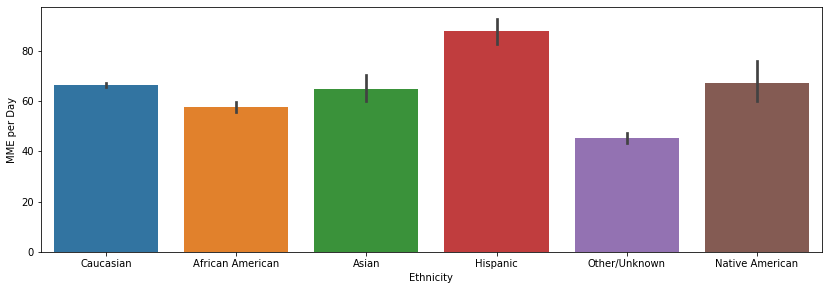

In [89]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=opi_stat, estimator=np.mean)
plt.xlabel('Ethnicity')
plt.ylabel('MME per Day')

In [90]:
# One Way ANOVA
stat.f_oneway(opi_stat_c,opi_stat_aa,opi_stat_a,opi_stat_h,opi_stat_na,opi_stat_o)

F_onewayResult(statistic=63.71946526218761, pvalue=1.0902822953035119e-66)

In [91]:
# Testing for Normal Distribution
k_c, p_c = stat.kstest(opi_stat_c, 'norm')
k_aa, p_aa = stat.kstest(opi_stat_aa, 'norm')
k_a, p_a = stat.kstest(opi_stat_a, 'norm')
k_h, p_h = stat.kstest(opi_stat_h, 'norm')
k_na, p_na = stat.kstest(opi_stat_na, 'norm')
k_o, p_o = stat.kstest(opi_stat_o, 'norm')

print('Caucasian: k-value:', k_c, 'p-value:', p_c)
print('African America: k-value:', k_aa, 'p-value:', p_aa)
print('Asian: k-value:', k_a, 'p-value:', p_a)
print('Hispanic: k-value:', k_h, 'p-value:', p_h)
print('Native American: k-value:', k_na, 'p-value:', p_na)
print('Other: k-value:', k_o, 'p-value:', p_o)

Caucasian: k-value: 0.7828788100453723 p-value: 0.0
African America: k-value: 0.7931229948202562 p-value: 0.0
Asian: k-value: 0.7853736591543353 p-value: 0.0
Hispanic: k-value: 0.910041258022052 p-value: 0.0
Native American: k-value: 0.7781318219188493 p-value: 0.0
Other: k-value: 0.7787180922507276 p-value: 0.0


If the P-Value of the KS Test is smaller than 0.05, we do not assume a normal distribution. Use non-parametric test.

In [92]:
# Kruskal-Wallis H-test
stat.kruskal(opi_stat_c,opi_stat_aa,opi_stat_a,opi_stat_h,opi_stat_na,opi_stat_o)

KruskalResult(statistic=508.62881644379434, pvalue=1.0955573639789447e-107)

In [95]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Multiple pairwise comparison (Tukey HSD)

m_comp = pairwise_tukeyhsd(endog=opi_stat['mme_per_day'], groups=opi_stat['ethnicity'], alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
African American,Asian,7.0126,0.2157,-1.8752,15.9004,False
African American,Caucasian,8.496,0.001,4.8129,12.179,True
African American,Hispanic,29.9434,0.001,22.7538,37.133,True
African American,Native American,9.6207,0.1527,-1.7558,20.9972,False
African American,Other/Unknown,-12.4066,0.001,-17.9401,-6.873,True
Asian,Caucasian,1.4834,0.9,-6.7865,9.7532,False
Asian,Hispanic,22.9308,0.001,12.6101,33.2515,True
Asian,Native American,2.6081,0.9,-10.9658,16.182,False
Asian,Other/Unknown,-19.4192,0.001,-28.6629,-10.1755,True
Caucasian,Hispanic,21.4474,0.001,15.0375,27.8574,True


Therefore, we conclude there is a significant difference between the means of groups:
- African American & Caucasian
- African American & Hispanic
- ~~African American & Unknown~~
- Asian & Hispanic
- ~~Asian & Unknown~~
- Caucasian & Hispanic
- ~~Caucasian & Unknown~~
- Hispanic & Native American
- ~~Hispanic & Unknown~~
- ~~Native American & Unknown~~